# Load the movement dataset

In [ ]:
# imports
import matplotlib.pyplot as plt
import numpy as np
from calibration_utils import (
    binning_based_calibration,
    plot_reliability_diagram,
)

from movement import sample_data
from movement.filtering import rolling_filter, savgol_filter

SHA256 hash of downloaded file: 40a6d79722dcaf7cee39627959e46a1bc10a6e1405842a7c2993d6d69b4c8195
Use this value as the 'known_hash' argument of 'pooch.retrieve' to ensure that the file hasn't changed if it is downloaded again in the future.


In [28]:
# Load DLC sample data
filename = "DLC_single-mouse_EPM.predictions.h5"
data = sample_data.fetch_dataset(filename)
# Print dataset structure
print(data)
# Check available variables
print(data.variables)

<xarray.Dataset> Size: 4MB
Dimensions:      (time: 18485, space: 2, keypoints: 8, individuals: 1)
Coordinates:
  * time         (time) float64 148kB 0.0 0.03333 0.06667 ... 616.1 616.1 616.1
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U13 416B 'snout' 'left_ear' ... 'tail_end'
  * individuals  (individuals) <U12 48B 'individual_0'
Data variables:
    position     (time, space, keypoints, individuals) float64 2MB 508.4 ... ...
    confidence   (time, keypoints, individuals) float64 1MB 0.0002829 ... 0.9978
Attributes:
    fps:              30.0
    time_unit:        seconds
    source_software:  DeepLabCut
    source_file:      C:/Users/subash/.movement/data/poses/DLC_single-mouse_E...
    ds_type:          poses
    frame_path:       C:\Users\subash\.movement\data\frames\single-mouse_EPM_...
    video_path:       None
Frozen({'time': <xarray.IndexVariable 'time' (time: 18485)> Size: 148kB
array([0.000000e+00, 3.333333e-02, 6.666667e-02, ..., 6.160667e+02,
    

## Extract confidencs scores

In [29]:
# extract confidence values
confidence_values = data["confidence"].values

# check if all values are NaN
print("Total NaN values:", np.isnan(confidence_values).sum())
print("Total confidence values:", confidence_values.size)

# Find frames that contain at least one non-NaN confidence score
valid_confidence_frames = np.where(
    ~np.isnan(confidence_values).any(axis=(1, 2))
)[0]
print("Frames with valid confidence scores:", valid_confidence_frames)
confidence_values.shape

Total NaN values: 0
Total confidence values: 147880
Frames with valid confidence scores: [    0     1     2 ... 18482 18483 18484]


(18485, 8, 1)

In [31]:
# Remove NaNs if any
confidence_values = confidence_values[~np.isnan(confidence_values)]

# Print summary statistics
print(f"Mean: {np.mean(confidence_values):.4f}")
print(f"Median: {np.median(confidence_values):.4f}")
print(f"Min: {np.min(confidence_values):.4f}")
print(f"Max: {np.max(confidence_values):.4f}")

Mean: 0.9461
Median: 0.9963
Min: 0.0000
Max: 1.0000


## Plot the distribution of confidence scores

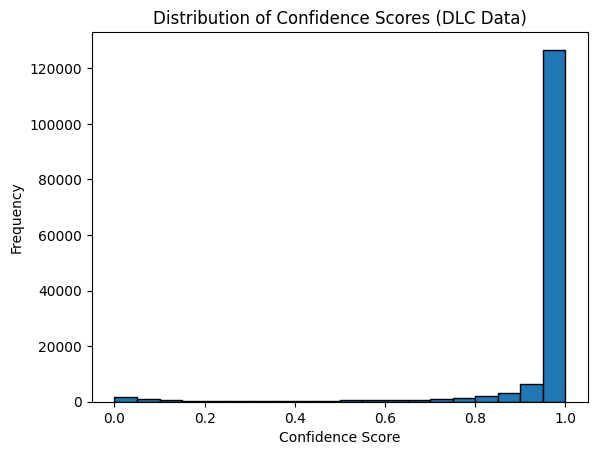

In [63]:
# Extract confidence scores from DLC dataset
confidence_values = data["confidence"].values.flatten()

# Plot histogram to see distribution
plt.hist(confidence_values, bins=20, edgecolor="black")
plt.xlabel("Confidence Score")
plt.ylabel("Frequency")
plt.title("Distribution of Confidence Scores (DLC Data)")
plt.show()

In [32]:
num_bins = 10  # Number of bins
bin_edges = np.linspace(0, 1, num_bins + 1)  # Create bin edges
bin_edges

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [33]:
binned_confidence, _ = np.histogram(confidence_values, bins=bin_edges)
avg_confidence_scores = np.mean(binned_confidence)
binned_confidence

array([  2396,    929,    707,    653,    821,   1062,   1352,   2178,
         4879, 132903])

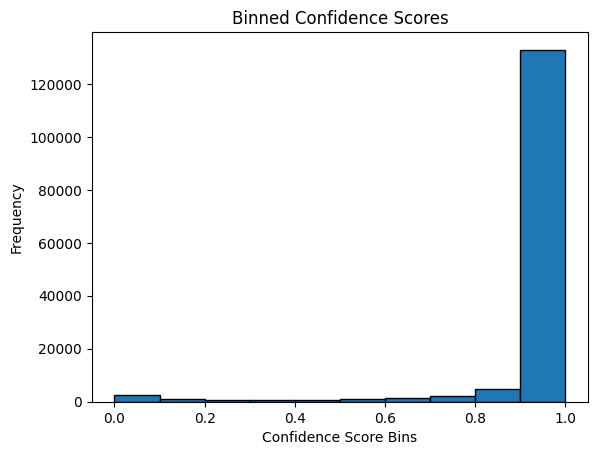

In [34]:
plt.bar(
    bin_edges[:-1],
    binned_confidence,
    width=0.1,
    edgecolor="black",
    align="edge",
)
plt.xlabel("Confidence Score Bins")
plt.ylabel("Frequency")
plt.title("Binned Confidence Scores")
plt.show()

In [35]:
positions = data["position"].values  # Extract (x, y) coordinates
confidences = data["confidence"].values  # Extract confidence scores

print("Position shape:", positions.shape)
print("Confidence shape:", confidences.shape)
print("Position shape:", positions)
print("Confidence shape:", confidences)

Position shape: (18485, 2, 8, 1)
Confidence shape: (18485, 8, 1)
Position shape: [[[[ 5.08378052e+02]
   [ 5.10629150e+02]
   [ 5.07475189e+02]
   ...
   [ 5.06161621e+02]
   [ 5.07490570e+02]
   [ 5.14233154e+02]]

  [[ 1.40388846e+00]
   [-6.92410469e-02]
   [-1.06969833e-01]
   ...
   [ 2.31207609e-01]
   [ 1.52716088e+00]
   [ 3.72320032e+00]]]


 [[[ 5.08386536e+02]
   [ 5.10652618e+02]
   [ 5.07442413e+02]
   ...
   [ 5.06196564e+02]
   [ 5.07487457e+02]
   [ 5.14126099e+02]]

  [[ 1.33792329e+00]
   [-1.26986980e-01]
   [-1.64947987e-01]
   ...
   [ 2.38292694e-01]
   [ 1.45037603e+00]
   [ 3.53412771e+00]]]


 [[[ 5.08348297e+02]
   [ 5.10648529e+02]
   [ 5.07420898e+02]
   ...
   [ 5.06199341e+02]
   [ 5.07453888e+02]
   [ 5.14019592e+02]]

  [[ 1.31977296e+00]
   [-1.77515507e-01]
   [-2.26914883e-01]
   ...
   [ 2.03141689e-01]
   [ 1.40643120e+00]
   [ 3.38258982e+00]]]


 ...


 [[[ 6.90422058e+02]
   [ 6.88076660e+02]
   [ 6.66580627e+02]
   ...
   [ 6.37829102e+02]
   [ 

## smoothing positions

In [ ]:
# Set smoothing window size (0.1 seconds of frames)
fps = data.attrs["fps"]  # Get FPS from dataset attributes
window = int(0.1 * fps)

# Apply Rolling Median Filter
smoothed_positions = rolling_filter(
    data["position"], window, statistic="median"
)

# Apply Savitzky-Golay Filter
smoothed_positions = savgol_filter(smoothed_positions, window)
smoothed_positions

<xarray.DataArray 'position' (time: 18485, space: 2, keypoints: 8,
                              individuals: 1)> Size: 2MB
508.4 510.7 507.4 509.8 506.1 506.2 ... 489.0 443.2 436.9 456.8 381.4 390.4
Coordinates:
  * time         (time) float64 148kB 0.0 0.03333 0.06667 ... 616.1 616.1 616.1
  * space        (space) <U1 8B 'x' 'y'
  * keypoints    (keypoints) <U13 416B 'snout' 'left_ear' ... 'tail_end'
  * individuals  (individuals) <U12 48B 'individual_0'
Attributes:
    log:      [{'operation': 'rolling_filter', 'datetime': '2025-03-23 02:40:...

In [37]:
# Compute velocity (change in position)
velocity = np.diff(smoothed_positions, axis=0)

# Compute acceleration (change in velocity)
acceleration = np.diff(velocity, axis=0)

# Compute acceleration magnitude
acceleration_magnitude = np.sqrt(np.sum(acceleration**2, axis=1))

print("Acceleration Shape:", acceleration.shape)
print("Sample Acceleration Magnitude:", acceleration_magnitude[:5])

Acceleration Shape: (18483, 2, 8, 1)
Sample Acceleration Magnitude: [[[2.79621057e-02]
  [4.64892007e-02]
  [6.55956310e-02]
  [2.34552921e-02]
  [4.20777908e-02]
  [2.09808350e-02]
  [5.52996284e-02]
  [1.85222395e-01]]

 [[2.29141400e-02]
  [4.21712093e-02]
  [5.91407522e-02]
  [1.73065765e-02]
  [3.58063145e-02]
  [6.27905080e-03]
  [3.82495787e-02]
  [1.34380484e-01]]

 [[4.87377548e-02]
  [1.36815715e-02]
  [2.23599921e-02]
  [5.14895469e-03]
  [1.01109628e-02]
  [3.39859254e-02]
  [5.00794041e-02]
  [4.79437475e-02]]

 [[5.69376092e-03]
  [1.86039564e-02]
  [1.09817346e-02]
  [3.47581991e-04]
  [3.48940639e-04]
  [4.41987214e-04]
  [1.50722473e-02]
  [1.41207463e-02]]

 [[7.02325452e-04]
  [3.84349681e-05]
  [8.48341416e-05]
  [3.47581991e-04]
  [6.73071315e-05]
  [3.27980785e-04]
  [6.11263577e-04]
  [3.64542007e-04]]]


##  Identify Uncertain Frames

In [38]:
threshold = np.percentile(acceleration_magnitude, 95)  # 95th percentile

# Mark frames with high acceleration as "uncertain"
uncertain_frames = acceleration_magnitude > threshold

print("Number of Uncertain Frames:", np.sum(uncertain_frames))
uncertain_frames

Number of Uncertain Frames: 7394


array([[[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       ...,

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]],

       [[False],
        [False],
        [False],
        ...,
        [False],
        [False],
        [False]]])

In [39]:
print("Confidence Values Shape:", confidence_values.shape)
print("Uncertain Frames Shape:", uncertain_frames.shape)

Confidence Values Shape: (147880,)
Uncertain Frames Shape: (18483, 8, 1)


In [40]:
# Reshape confidence_values to match (frames, keypoints, individuals)
num_frames = 18485  # From DLC dataset
num_keypoints = 8  # From DLC dataset
num_individuals = 1  # Only one tracked mouse

confidence_values = confidence_values.reshape(
    num_frames, num_keypoints, num_individuals
)
print("Reshaped Confidence Values Shape:", confidence_values.shape)

Reshaped Confidence Values Shape: (18485, 8, 1)


In [ ]:
# Convert uncertain_frames to match confidence_values first dimension
uncertain_confidences = confidence_values[uncertain_frames.nonzero()[0], :, :]

# Print stats
print(
    f"Mean Confidence of Uncertain Frames: "
    f"{np.mean(uncertain_confidences):.4f}"
)
print(
    f"Median Confidence of Uncertain Frames:"
    f"{np.median(uncertain_confidences):.4f}"
)

Mean Confidence of Uncertain Frames: 0.9166
Median Confidence of Uncertain Frames: 0.9947


## Plot histogram for overall confidence & uncertain confidence

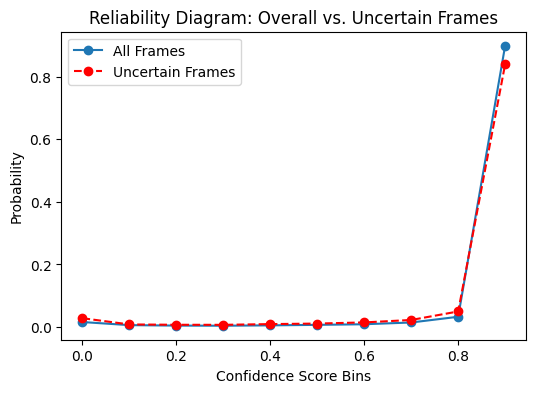

In [ ]:
# Define bins (same as before)
num_bins = 10
bin_edges = np.linspace(0, 1, num_bins + 1)

# Compute histogram for overall confidence & uncertain confidence
overall_counts, _ = np.histogram(confidence_values.flatten(), bins=bin_edges)
uncertain_counts, _ = np.histogram(
    uncertain_confidences.flatten(), bins=bin_edges
)

# Normalize to probability distribution
overall_prob = overall_counts / np.sum(overall_counts)
uncertain_prob = uncertain_counts / np.sum(uncertain_counts)

# Plot reliability diagram
plt.figure(figsize=(6, 4))
plt.plot(bin_edges[:-1], overall_prob, label="All Frames", marker="o")
plt.plot(
    bin_edges[:-1],
    uncertain_prob,
    label="Uncertain Frames",
    marker="o",
    linestyle="dashed",
    color="red",
)

plt.xlabel("Confidence Score Bins")
plt.ylabel("Probability")
plt.title("Reliability Diagram: Overall vs. Uncertain Frames")
plt.legend()
plt.show()

In [ ]:
# Example Usage
np.random.seed(42)  # For reproducibility
confidences = np.random.rand(1000)  # Simulated confidence scores
labels = (
    confidences + np.random.normal(0, 0.1, 1000)
) > 0.5  # Simulated correctness labels

calibrated_confidences, bin_edges, bin_accuracies = binning_based_calibration(
    confidences, labels
)
print("Original Confidence Mean:", np.mean(confidences))
print("Calibrated Confidence Mean:", np.mean(calibrated_confidences))

Original Confidence Mean: 0.4902565533201336
Calibrated Confidence Mean: 0.504


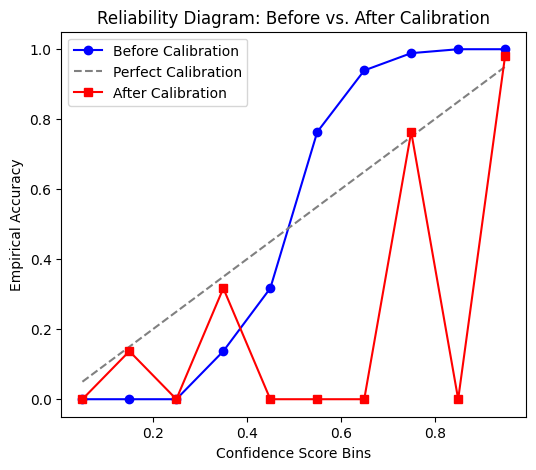

In [ ]:
# Plot the Reliability Diagram
plot_reliability_diagram(
    confidences, calibrated_confidences, labels, bin_edges
)

In [ ]:
# Compute and print ECE
from calibration_utils import compute_ece

ece_before, ece_after = compute_ece(
    confidences, calibrated_confidences, labels, bin_edges
)
print(f"Expected Calibration Error (ECE) Before Calibration: {ece_before:.4f}")
print(f"Expected Calibration Error (ECE) After Calibration: {ece_after:.4f}")

Expected Calibration Error (ECE) Before Calibration: 0.1734
Expected Calibration Error (ECE) After Calibration: 0.0000
